In [5]:
# ===============================================================
# 💾 01_a_processing_v18_WITH_AWARDS_EXPERIENCE_PLUS.py
# ===============================================================
# 🧠 Objetivo:
# - Baseado no v17_WITH_AWARDS (rookies melhorados)
# - Adiciona experiência média + talento individual (star power)
# - Inclui impacto do sucesso nos playoffs (postseason_boost)
# - Mantém prémios e rookies por posição (G/F/C)
# ===============================================================

import pandas as pd
import numpy as np
import os

print(">>> [a) v18+] A construir dataset com AWARDS + EXPERIENCE + STAR POWER + POSTSEASON BOOST...")

# ===============================================================
# 1️⃣ Ler dados
# ===============================================================
players_teams = pd.read_csv("data/players_teams.csv")
teams = pd.read_csv("data/teams.csv")
awards = pd.read_csv("data/awards_players.csv")
players = pd.read_csv("data/players.csv")

for df in (players_teams, teams, awards):
    if "year" in df.columns:
        df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
        df.dropna(subset=["year"], inplace=True)
        df["year"] = df["year"].astype(int)

# ===============================================================
# 2️⃣ Tratar posições e experiência dos jogadores
# ===============================================================
players["pos"] = players["pos"].fillna("")
players["pos_group"] = (
    players["pos"].str.upper().str.replace(" ", "").str.replace("-", "")
)

def map_pos_group(p):
    if "G" in p:
        return "G"
    if "F" in p:
        return "F"
    if "C" in p:
        return "C"
    return "X"

players["pos_group"] = players["pos_group"].apply(map_pos_group)
players["experience_years"] = (
    (players["lastseason"] - players["firstseason"]).clip(lower=0).fillna(0)
)

# ===============================================================
# 3️⃣ Calcular rating anual por jogador (T) — com mais estatísticas
# ===============================================================
cols_needed = ["playerID", "year", "points", "rebounds", "assists", "steals", "blocks",
               "turnovers", "minutes", "fgMade", "fgAttempted", "threeMade",
               "threeAttempted", "ftMade", "ftAttempted", "PF", "GP"]
for c in cols_needed:
    if c not in players_teams.columns:
        players_teams[c] = 0

agg = (
    players_teams.groupby(["playerID", "year"], as_index=False)
    .agg(
        GP=("GP", "sum"),
        minutes=("minutes", "sum"),
        points=("points", "sum"),
        rebounds=("rebounds", "sum"),
        assists=("assists", "sum"),
        steals=("steals", "sum"),
        blocks=("blocks", "sum"),
        turnovers=("turnovers", "sum"),
        PF=("PF", "sum"),
        fgMade=("fgMade", "sum"),
        fgAttempted=("fgAttempted", "sum"),
        threeMade=("threeMade", "sum"),
        threeAttempted=("threeAttempted", "sum"),
        ftMade=("ftMade", "sum"),
        ftAttempted=("ftAttempted", "sum"),
    )
)


agg["FG%"] = np.where(agg["fgAttempted"] > 0, agg["fgMade"] / agg["fgAttempted"], 0)
agg["3P%"] = np.where(agg["threeAttempted"] > 0, agg["threeMade"] / agg["threeAttempted"], 0)
agg["FT%"] = np.where(agg["ftAttempted"] > 0, agg["ftMade"] / agg["ftAttempted"], 0)

# Weighted Efficiency Index (estilo PER)
agg["player_rating"] = (
    (agg["points"])
    + (agg["rebounds"] * 1.2)
    + (agg["assists"] * 1.5)
    + (agg["steals"] * 3.0)
    + (agg["blocks"] * 3.0)
    + (agg["threeMade"] * 0.8)
    - (agg["turnovers"] * 2.0)
    - (agg["PF"] * 0.5)
) / (agg["minutes"] / 36 + 1)

agg["eff_bonus"] = 0.5 * agg["FG%"] + 0.3 * agg["FT%"] + 0.2 * agg["3P%"]
agg["player_rating"] *= (1 + agg["eff_bonus"])

agg = agg[(agg["minutes"] >= 100) & (agg["minutes"] < agg["minutes"].quantile(0.99))].copy()

# ===============================================================
# 4️⃣ Criar mapa T−1
# ===============================================================
prev_map = agg.rename(columns={"year": "year_prev", "player_rating": "player_rating_prev"})
prev_map["year"] = prev_map["year_prev"] + 1
prev_map = prev_map[["playerID", "year", "player_rating_prev"]]

# ===============================================================
# 5️⃣ Integrar AWARDS (exclui Coach of the Year)
# ===============================================================
award_counts = (
    awards[awards["award"] != "Coach of the Year"]
    .groupby(["playerID", "year"])["award"].count().reset_index()
    .rename(columns={"award": "num_awards"})
)
prev_map = prev_map.merge(award_counts, on=["playerID", "year"], how="left")
prev_map["num_awards"] = prev_map["num_awards"].fillna(0)
AWARD_BOOST = 1.7
prev_map["player_rating_prev"] *= (1 + AWARD_BOOST * prev_map["num_awards"])

# ===============================================================
# 6️⃣ Rookies (com posição)
# ===============================================================
roster = players_teams[["playerID", "tmID", "year"]].drop_duplicates()
roster_prev = roster.merge(prev_map, on=["playerID", "year"], how="left")
roster_prev = roster_prev.merge(
    players[["bioID", "pos_group", "experience_years"]],
    left_on="playerID", right_on="bioID", how="left"
).drop(columns=["bioID"])

pos_means = roster_prev.dropna(subset=["player_rating_prev"]).groupby("pos_group")["player_rating_prev"].mean()
mean_rating_prev_global = roster_prev["player_rating_prev"].mean(skipna=True)
ROOKIE_PENALTY = 0.8

roster_prev["is_rookie"] = roster_prev["player_rating_prev"].isna().astype(int)
mask_rookies = roster_prev["is_rookie"] == 1
rookie_base_by_pos = roster_prev.loc[mask_rookies, "pos_group"].map(pos_means).fillna(mean_rating_prev_global)
roster_prev.loc[mask_rookies, "player_rating_prev"] = rookie_base_by_pos * ROOKIE_PENALTY
roster_prev["experience_years"] = roster_prev["experience_years"].fillna(0)

# ===============================================================
# 7️⃣ Agregar nível equipa + talento máximo (STAR POWER)
# ===============================================================
team_sum = (
    roster_prev.groupby(["tmID", "year"], as_index=False)
    .agg(
        team_sum_prev_rating=("player_rating_prev", "sum"),
        avg_player_rating=("player_rating_prev", "mean"),
        top_player_rating_prev=("player_rating_prev", "max"),
        num_players=("playerID", "count"),
        num_rookies=("is_rookie", "sum"),
        team_total_awards=("num_awards", "sum"),
        avg_awards_per_player=("num_awards", "mean"),
        avg_experience_years=("experience_years", "mean")
    )
)
team_sum["rookie_ratio_prev"] = team_sum["num_rookies"] / team_sum["num_players"].replace(0, np.nan)

# Elite ratio
elite_cutoff = roster_prev["player_rating_prev"].quantile(0.9)
elite_ratio = (
    roster_prev.assign(is_elite=lambda x: (x["player_rating_prev"] >= elite_cutoff).astype(int))
    .groupby(["tmID", "year"], as_index=False)["is_elite"].mean()
    .rename(columns={"is_elite": "elite_ratio_prev"})
)
team_sum = team_sum.merge(elite_ratio, on=["tmID", "year"], how="left")
team_sum.fillna(0, inplace=True)

# Histórico da equipa (T−1)
teams = teams.sort_values(["tmID", "year"]).copy()
for col in ["rank", "won", "lost", "GP", "o_pts", "d_pts"]:
    teams[f"{col}_prev"] = teams.groupby("tmID")[col].shift(1)

teams["win_pct_prev"] = teams["won_prev"] / teams["GP_prev"].replace(0, np.nan)
teams["margin_prev"] = (teams["o_pts_prev"] - teams["d_pts_prev"]) / teams["GP_prev"].replace(0, np.nan)

data_ready = teams.merge(team_sum, on=["tmID", "year"], how="left")

# ===============================================================
# 9️⃣ Coach of the Year (T−1)
# ===============================================================
coach_awards = (
    awards[awards["award"] == "Coach of the Year"]
    .assign(year=lambda x: x["year"] + 1, has_coach_award_prev=1)[["playerID", "year", "has_coach_award_prev"]]
)
data_ready = data_ready.merge(coach_awards.rename(columns={"playerID": "tmID"}), on=["tmID", "year"], how="left")
data_ready["has_coach_award_prev"] = data_ready["has_coach_award_prev"].fillna(0)

# ===============================================================
# 🏆 Postseason Boost
# ===============================================================
if "PostPoints" in players_teams.columns:
    playoff_stats = (
        players_teams.groupby(["playerID", "year"], as_index=False)
        .agg(
            PostPoints=("PostPoints", "sum"),
            PostRebounds=("PostRebounds", "sum"),
            PostAssists=("PostAssists", "sum"),
            PostSteals=("PostSteals", "sum"),
            PostBlocks=("PostBlocks", "sum"),
            PostTurnovers=("PostTurnovers", "sum"),
            PostMinutes=("PostMinutes", "sum"),
        )
    )
    playoff_stats["player_post_rating"] = (
        playoff_stats["PostPoints"]
        + 1.2 * playoff_stats["PostRebounds"]
        + 1.5 * playoff_stats["PostAssists"]
        + 3.0 * playoff_stats["PostSteals"]
        + 3.0 * playoff_stats["PostBlocks"]
        - 2.0 * playoff_stats["PostTurnovers"]
    ) / (playoff_stats["PostMinutes"].fillna(0) + 1)

    playoff_team_sum = (
        players_teams.merge(playoff_stats[["playerID", "year", "player_post_rating"]], on=["playerID", "year"], how="left")
        .groupby(["tmID", "year"], as_index=False)["player_post_rating"]
        .mean()
        .rename(columns={"player_post_rating": "team_postseason_score"})
    )
    playoff_team_sum["year"] += 1
else:
    playoff_team_sum = pd.DataFrame(columns=["tmID", "year", "team_postseason_score"])

team_sum = team_sum.merge(playoff_team_sum, on=["tmID", "year"], how="left")
team_sum.fillna(0, inplace=True)

mean_val, std_val = team_sum["team_postseason_score"].mean(), team_sum["team_postseason_score"].std()
team_sum["postseason_boost"] = (team_sum["team_postseason_score"] - mean_val) / std_val if std_val > 0 else 0

# ===============================================================
# 🔍 Merge seguro (mantém todas as colunas, incluindo has_coach_award_prev)
# ===============================================================
data_ready = data_ready.merge(team_sum, on=["tmID", "year"], how="left", suffixes=("", "_new"))

for col in [c for c in data_ready.columns if c.endswith("_new")]:
    base_col = col.replace("_new", "")
    if base_col not in data_ready or data_ready[base_col].isna().all():
        data_ready[base_col] = data_ready[col]
    data_ready.drop(columns=[col], inplace=True, errors="ignore")

# ===============================================================
# 🔍 Limpeza e normalização
# ===============================================================
data_ready.replace([np.inf, -np.inf], np.nan, inplace=True)
data_ready.fillna(0, inplace=True)

for col in [
    "team_sum_prev_rating", "avg_player_rating", "margin_prev",
    "avg_awards_per_player", "avg_experience_years",
    "top_player_rating_prev", "elite_ratio_prev", "postseason_boost"
]:
    if col not in data_ready.columns:
        continue
    low, high = data_ready[col].quantile([0.02, 0.98])
    data_ready[col] = data_ready[col].clip(lower=low, upper=high)
    mean_val, std_val = data_ready[col].mean(), data_ready[col].std()
    if std_val > 0:
        data_ready[col] = (data_ready[col] - mean_val) / std_val

# ===============================================================
# 💾 Guardar
# ===============================================================
final_cols = [
    "tmID", "year", "confID", "won", "rank",
    "rank_prev", "win_pct_prev", "margin_prev",
    "team_sum_prev_rating", "avg_player_rating",
    "top_player_rating_prev", "elite_ratio_prev",
    "rookie_ratio_prev", "team_total_awards", "avg_awards_per_player",
    "avg_experience_years", "postseason_boost",
    "has_coach_award_prev"
]

final_data = data_ready[final_cols].copy()
os.makedirs("a", exist_ok=True)
out_path = "a/teams_a_v18_with_awards_experience_plus.csv"
final_data.to_csv(out_path, index=False, encoding="utf-8")

print(f"\n💾 Guardado em '{out_path}'")
print("✅ Dataset v18_WITH_AWARDS_EXPERIENCE_PLUS criado com sucesso (⭐ STAR POWER + 🏆 POSTSEASON BOOST).")




>>> [a) v18+] A construir dataset com AWARDS + EXPERIENCE + STAR POWER + POSTSEASON BOOST...

💾 Guardado em 'a/teams_a_v18_with_awards_experience_plus.csv'
✅ Dataset v18_WITH_AWARDS_EXPERIENCE_PLUS criado com sucesso (⭐ STAR POWER + 🏆 POSTSEASON BOOST).


>>> [v19 TRAIN MODEL] A treinar e avaliar modelo v19...


📊 Resultados por ano (v19):
   year    MAE  Spearman
0     2  1.125     0.821
1     3  1.625     0.440
2     4  1.714     0.554
3     5  1.077     0.658
4     6  0.615     0.866
5     7  0.571     0.929
6     8  1.077     0.641
7     9  1.714     0.464
8    10  1.692     0.328

📈 Média MAE: 1.246
📈 Média Spearman: 0.633

📌 Spearman por conferência por ano:
   year  Conf_EA  Conf_WE
0     2    0.738    0.905
1     3    0.143    0.738
2     4    0.429    0.679
3     5    0.314    0.857
4     6    0.943    0.821
5     7    0.964    0.893
6     8    0.886    0.464
7     9    0.679    0.250
8    10    0.143    0.543

📌 Variância total dos Spearmans (todas conferências): 0.0739
📌 Desvio padrão total: 0.27184

📌 Coeficientes do modelo global v19:
margin_prev         -0.3064
avg_player_rating   -0.4789
team_total_awards   -0.5934
elite_ratio_prev    -0.2451
dtype: float64


/tmp/ipykernel_31624/228346967.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred_raw"] = model.predict(X_test)
/tmp/ipykernel_31624/228346967.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred_rank"] = test.groupby("confID")["pred_raw"].rank(ascending=True, method="min")
/tmp/ipykernel_31624/228346967.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

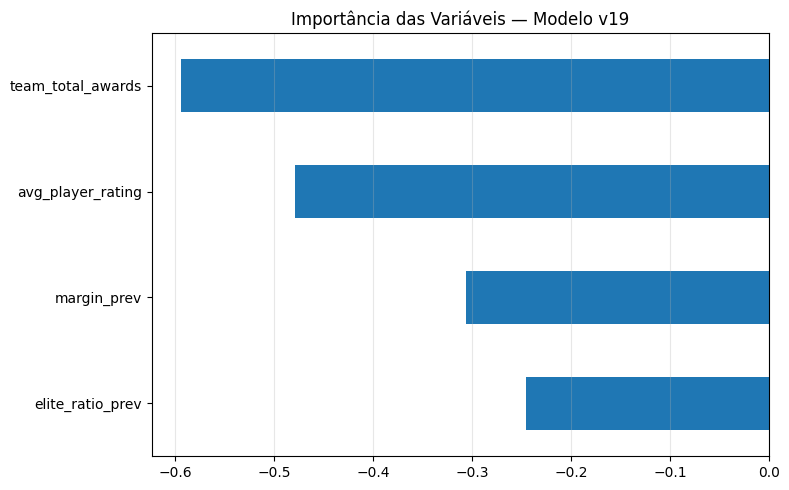


🏆 Previsão da última época de treino guardada em:
a/predicted_train_lastseason_v19.csv


/tmp/ipykernel_31624/228346967.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred_raw"] = model_final.predict(test[X_COLS])
/tmp/ipykernel_31624/228346967.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["rank_pred"] = test.groupby("confID")["pred_raw"].rank(ascending=True, method="min")


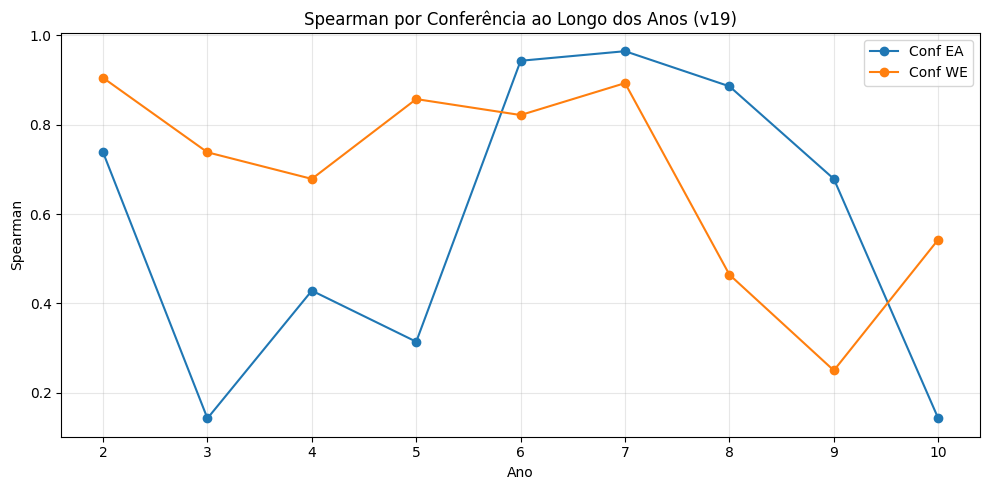

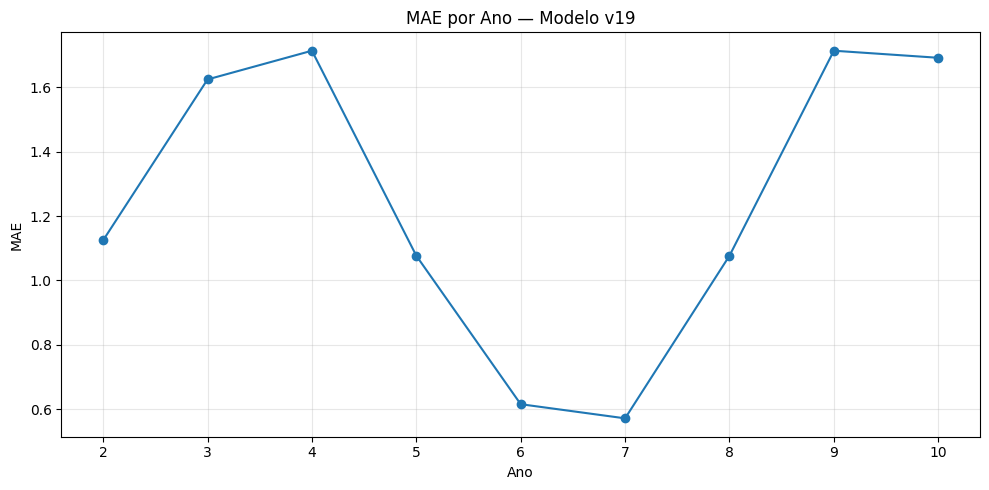


📌 --- Estatísticas Globais dos Spearmans (todas as conferências) ---
Total de valores usados: 18
Variância total (todas confs): 0.07390
Desvio padrão total (todas confs): 0.27184
---------------------------------------------------------------------

💾 Modelo treinado guardado em: a/model_v19.pkl
✔ Agora já podes correr 04_a_predict_v19.py


In [6]:
# ===============================================================
# 🤖 03_a_train_model_v19.py (versão completa estilo v18)
# ===============================================================
# - Avaliação multi-ano
# - MAE e Spearman por ano
# - Spearman por conferência
# - Variância total dos Spearmans (todas conferências)
# - Coeficientes
# - Gráficos
# - Previsão da última época
# ===============================================================

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr

print(">>> [v19 TRAIN MODEL] A treinar e avaliar modelo v19...\n")

# -----------------------------
# 1. Carregar dataset TRAIN
# -----------------------------
DATA_PATH = "a/teams_a_v18_with_awards_experience_plus.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("❌ 'teams_train_v19.csv' não existe. Corre o script 01.")

data = pd.read_csv(DATA_PATH)

years = sorted(data["year"].unique())

# -----------------------------
# 2. Features v19
# -----------------------------
X_COLS = [
    "margin_prev",
    "avg_player_rating",
    "team_total_awards",
    "elite_ratio_prev",
]


def evaluate_year(test_year):
    train = data[data["year"] < test_year]
    test = data[data["year"] == test_year]

    if len(train) == 0 or len(test) == 0:
        return None

    X_train = train[X_COLS]
    y_train = train["rank"].astype(float)

    X_test = test[X_COLS]
    y_test = test["rank"].astype(float)

    model = LinearRegression()
    model.fit(X_train, y_train)

    test["pred_raw"] = model.predict(X_test)

    test["pred_rank"] = test.groupby("confID")["pred_raw"].rank(ascending=True, method="min")

    mae = mean_absolute_error(y_test, test["pred_rank"])
    spearman, _ = spearmanr(y_test, test["pred_rank"])

    preds = test[["tmID", "year", "confID", "rank", "pred_rank"]].copy()

    return {"year": test_year, "MAE": mae, "Spearman": spearman, "preds": preds}

# Avaliar todos os anos
results = [evaluate_year(y) for y in years if y > min(years)]
results = [r for r in results if r]

df_eval = pd.DataFrame([{"year": r["year"], "MAE": r["MAE"], "Spearman": r["Spearman"]} for r in results])
preds_all = pd.concat([r["preds"] for r in results])

print("\n📊 Resultados por ano (v19):")
print(df_eval.round(3))
print(f"\n📈 Média MAE: {df_eval['MAE'].mean():.3f}")
print(f"📈 Média Spearman: {df_eval['Spearman'].mean():.3f}")

# -----------------------------
# 4. Spearman por conferência
# -----------------------------
conference_ids = sorted(preds_all["confID"].unique())
spearman_by_conf = []

for year in df_eval["year"]:
    df_y = preds_all[preds_all["year"] == year]
    row = {"year": year}
    for conf in conference_ids:
        df_c = df_y[df_y["confID"] == conf]
        if len(df_c) > 1:
            sp, _ = spearmanr(df_c["rank"], df_c["pred_rank"])
            row[f"Conf_{conf}"] = sp
        else:
            row[f"Conf_{conf}"] = np.nan
    spearman_by_conf.append(row)

df_spearman_conf = pd.DataFrame(spearman_by_conf)

print("\n📌 Spearman por conferência por ano:")
print(df_spearman_conf.round(3))

# -----------------------------
# 5. Variância total de Spearman (todas confs)
# -----------------------------
all_spearmans = []

for conf in conference_ids:
    col = f"Conf_{conf}"
    if col in df_spearman_conf.columns:
        all_spearmans.extend(df_spearman_conf[col].dropna().values.tolist())

var_total = np.var(all_spearmans)
std_total = np.std(all_spearmans)

print("\n📌 Variância total dos Spearmans (todas conferências):", round(var_total, 5))
print("📌 Desvio padrão total:", round(std_total, 5))

# -----------------------------
# 6. Coeficientes do modelo global
# -----------------------------
X_full = data[X_COLS]
y_full = data["rank"].astype(float)

model_full = LinearRegression().fit(X_full, y_full)
coefs = pd.Series(model_full.coef_, index=X_COLS)

print("\n📌 Coeficientes do modelo global v19:")
print(coefs.round(4))

plt.figure(figsize=(8, 5))
coefs.reindex(coefs.abs().sort_values().index).plot(kind="barh")
plt.title("Importância das Variáveis — Modelo v19")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 7. Previsão da última época
# -----------------------------
test_year = max(years)
train = data[data["year"] < test_year]
test = data[data["year"] == test_year]

model_final = LinearRegression().fit(train[X_COLS], train["rank"].astype(float))

test["pred_raw"] = model_final.predict(test[X_COLS])
test["rank_pred"] = test.groupby("confID")["pred_raw"].rank(ascending=True, method="min")

final_output = test[["tmID", "confID", "year", "rank_pred"]].sort_values(["confID", "rank_pred"])

out_path = "a/predicted_train_lastseason_v19.csv"
final_output.to_csv(out_path, index=False)

print("\n🏆 Previsão da última época de treino guardada em:")
print(out_path)

# -----------------------------
# 8. Gráfico Spearman por conf
# -----------------------------
plt.figure(figsize=(10, 5))

for conf in conference_ids:
    plt.plot(
        df_spearman_conf["year"],
        df_spearman_conf[f"Conf_{conf}"],
        marker="o",
        label=f"Conf {conf}"
    )

plt.xlabel("Ano")
plt.ylabel("Spearman")
plt.title("Spearman por Conferência ao Longo dos Anos (v19)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 9. Gráfico MAE por ano
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(df_eval["year"], df_eval["MAE"], marker="o")
plt.title("MAE por Ano — Modelo v19")
plt.xlabel("Ano")
plt.ylabel("MAE")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===============================================================
# 📊 Variância usando TODOS os valores de Spearman (todas as conferências, todos os anos)
# ===============================================================

# Vetor com todos os valores de Spearman por conferência
all_spearmans = []

for conf in conference_ids:
    # Coluna "Conf_X"
    col = f"Conf_{conf}"
    if col in df_spearman_conf.columns:
        all_spearmans.extend(df_spearman_conf[col].dropna().values.tolist())

# Variância populacional
variance_all_spearman = np.var(all_spearmans, ddof=0)
std_all_spearman = np.std(all_spearmans, ddof=0)

print("\n📌 --- Estatísticas Globais dos Spearmans (todas as conferências) ---")
print(f"Total de valores usados: {len(all_spearmans)}")
print(f"Variância total (todas confs): {variance_all_spearman:.5f}")
print(f"Desvio padrão total (todas confs): {std_all_spearman:.5f}")
print("---------------------------------------------------------------------")

# ===============================================================
# 10. Guardar modelo global treinado para uso no TEST SET
# ===============================================================

import pickle

MODEL_PATH = "a/model_v19.pkl"

with open(MODEL_PATH, "wb") as f:
    pickle.dump(model_full, f)

print("\n💾 Modelo treinado guardado em:", MODEL_PATH)
print("✔ Agora já podes correr 04_a_predict_v19.py")


>>> [v19 TRAIN MODEL] Treinar modelos separados por conferência...


📊 Resultados por ano e conferência:
    year confID    MAE  Spearman
0      2     EA  2.875    -0.082
1      2     WE  0.750     0.905
2      3     EA  2.125     0.216
3      3     WE  1.250     0.714
4      4     EA  1.429     0.464
5      4     WE  1.143     0.714
6      5     EA  1.667     0.086
7      5     WE  0.857     0.821
8      6     EA  0.667     0.829
9      6     WE  0.857     0.750
10     7     EA  1.143     0.714
11     7     WE  1.429     0.643
12     8     EA  0.667     0.829
13     8     WE  1.714     0.357
14     9     EA  1.429     0.607
15     9     WE  2.000     0.250
16    10     EA  1.429     0.500
17    10     WE  1.333     0.429

📈 Média MAE: 1.376
📈 Média Spearman: 0.541
📌 Variância MAE: 0.32179
📌 Variância Spearman: 0.08032

🔍 Importância das features por conferência:

📌 Importância EA (RF):
margin_prev          0.1841
avg_player_rating    0.5829
team_total_awards    0.1056
elite_ratio_prev

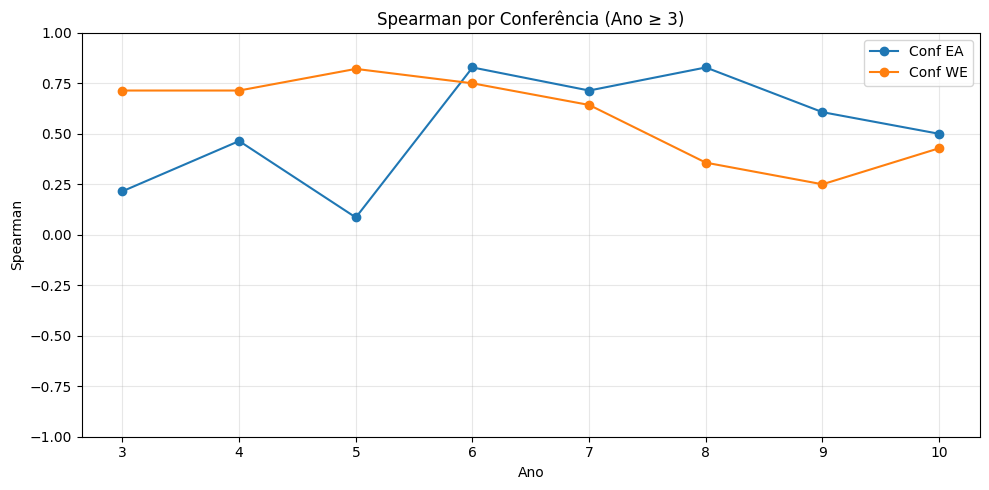


📌 Média Spearman por conferência (Ano ≥ 3):
Conf_EA    0.531
Conf_WE    0.585
dtype: float64

📌 Variância Spearman por conferência (Ano ≥ 3):
Conf_EA    0.07424
Conf_WE    0.04407
dtype: float64

📌 Spearman geral (todas conferências, Ano ≥ 3):
Média: 0.5577
Variância: 0.05250

📌 Spearman geral (todas conferências, Ano ≥ 3):

💾 A guardar modelos treinados por conferência...
✔ Modelo da conferência EA guardado em: a/models_by_conf/model_EA_v19.pkl
✔ Modelo da conferência WE guardado em: a/models_by_conf/model_WE_v19.pkl

Todos os modelos foram guardados com sucesso!


In [2]:
# ===============================================================
# 🤖 03_a_train_model_v19_by_conf.py
# ===============================================================
# Treina modelos separados por conferência
# - Western Conference (WE): Linear Regression
# - Eastern Conference (EA): Random Forest
# Mantém:
# - Avaliação multi-ano
# - MAE e Spearman por ano
# - Spearman por conferência
# - Variância total dos Spearmans (todas as conferências)
# - Coeficientes / importância das features
# - Gráficos
# - Previsão da última época
# ===============================================================

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
import pickle

print(">>> [v19 TRAIN MODEL] Treinar modelos separados por conferência...\n")

# -----------------------------
# 1. Carregar dataset
# -----------------------------
DATA_PATH = "a/teams_a_v18_with_awards_experience_plus.csv"
data = pd.read_csv(DATA_PATH)
years = sorted(data["year"].unique())

# -----------------------------
# 2. Features
# -----------------------------
X_COLS = [
    "margin_prev",
    "avg_player_rating",
    "team_total_awards",
    "elite_ratio_prev",
]

# -----------------------------
# 3. Avaliação multi-ano por conferência
# -----------------------------
conference_models = {"EA": RandomForestRegressor(n_estimators=400, min_samples_leaf=2, random_state=42, n_jobs=-1),
                     "WE": LinearRegression()}

results = []
preds_all = []

for test_year in years:
    year_preds = []
    for conf, model in conference_models.items():
        train = data[(data["year"] < test_year) & (data["confID"] == conf)]
        test = data[(data["year"] == test_year) & (data["confID"] == conf)]
        if train.empty or test.empty:
            continue

        X_train, y_train = train[X_COLS], train["rank"].astype(float)
        X_test, y_test = test[X_COLS], test["rank"].astype(float)

        model.fit(X_train, y_train)
        test = test.copy()
        test["rank_pred_raw"] = model.predict(X_test)
        test["rank_pred_model"] = test["rank_pred_raw"].rank(ascending=True, method="min")

        mae = mean_absolute_error(y_test, test["rank_pred_model"])
        spearman, _ = spearmanr(y_test, test["rank_pred_model"])

        year_preds.append(test[["tmID", "year", "confID", "rank", "rank_pred_model"]])
        results.append({"year": test_year, "confID": conf, "MAE": mae, "Spearman": spearman})

    if year_preds:
        preds_all.append(pd.concat(year_preds, ignore_index=True))

# -----------------------------
# 4. Resultados consolidados
# -----------------------------
df_eval = pd.DataFrame(results)
preds_all = pd.concat(preds_all, ignore_index=True)

print("\n📊 Resultados por ano e conferência:")
print(df_eval.round(3))

# Estatísticas globais
mean_mae = df_eval["MAE"].mean()
mean_spearman = df_eval["Spearman"].mean()
var_mae = df_eval["MAE"].var()
var_spearman = df_eval["Spearman"].var()

print(f"\n📈 Média MAE: {mean_mae:.3f}")
print(f"📈 Média Spearman: {mean_spearman:.3f}")
print(f"📌 Variância MAE: {var_mae:.5f}")
print(f"📌 Variância Spearman: {var_spearman:.5f}")

os.makedirs("a", exist_ok=True)
df_eval.to_csv("a/eval_v19_by_conf.csv", index=False, encoding="utf-8")

# -----------------------------
# 5. Importância / Coeficientes por modelo
# -----------------------------
print("\n🔍 Importância das features por conferência:")
for conf, model in conference_models.items():
    X_full = data[data["confID"] == conf][X_COLS]
    y_full = data[data["confID"] == conf]["rank"].astype(float)
    model.fit(X_full, y_full)

    if conf == "WE":  # Linear Regression
        coefs = pd.Series(model.coef_, index=X_COLS)
        print(f"\n📌 Coeficientes WE (LR):")
        print(coefs.round(4))
    else:  # EA: Random Forest
        importances = pd.Series(model.feature_importances_, index=X_COLS)
        print(f"\n📌 Importância EA (RF):")
        print(importances.round(4))

# -----------------------------
# 6. Previsão última época
# -----------------------------
test_year = max(years)
final_preds = []

for conf, model in conference_models.items():
    train = data[(data["year"] < test_year) & (data["confID"] == conf)]
    test = data[(data["year"] == test_year) & (data["confID"] == conf)]
    X_train, y_train = train[X_COLS], train["rank"].astype(float)
    X_test = test[X_COLS]

    model.fit(X_train, y_train)
    test = test.copy()
    test["rank_pred_raw"] = model.predict(X_test)
    test["rank_pred"] = test["rank_pred_raw"].rank(ascending=True, method="min")
    final_preds.append(test[["tmID", "confID", "year", "rank_pred"]])

final_output = pd.concat(final_preds).sort_values(["confID", "rank_pred"])
final_output.to_csv("a/predicted_ranking_test_season_v19_by_conf.csv", index=False, encoding="utf-8")

print("\n🏆 Previsão final da época guardada em:")
print("a/predicted_ranking_test_season_v19_by_conf.csv")

# -----------------------------
# 7. Gráfico Spearman por conferência
# -----------------------------
conference_ids = sorted(preds_all["confID"].unique())
spearman_by_conf = []

for year in df_eval["year"].unique():
    df_y = preds_all[preds_all["year"] == year]
    row = {"year": year}
    for conf in conference_ids:
        df_c = df_y[df_y["confID"] == conf]
        if len(df_c) > 1:
            sp, _ = spearmanr(df_c["rank"], df_c["rank_pred_model"])
        else:
            sp = np.nan
        row[f"Conf_{conf}"] = sp
    spearman_by_conf.append(row)

df_spearman_conf = pd.DataFrame(spearman_by_conf)

plt.figure(figsize=(10, 5))
df_plot = df_spearman_conf[df_spearman_conf["year"] >= 3]
for conf in conference_ids:
    plt.plot(df_plot["year"], df_plot[f"Conf_{conf}"], marker="o", label=f"Conf {conf}")
plt.xlabel("Ano")
plt.ylabel("Spearman")
plt.title("Spearman por Conferência (Ano ≥ 3)")
plt.ylim(-1, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

df_spearman_conf.to_csv("a/spearman_conf_v19_by_conf.csv", index=False)

# Selecionar apenas anos >= 3
df_spearman_after3 = df_spearman_conf[df_spearman_conf["year"] >= 3].drop(columns="year")

# Média por conferência
mean_spearman_conf_after3 = df_spearman_after3.mean()
print("\n📌 Média Spearman por conferência (Ano ≥ 3):")
print(mean_spearman_conf_after3.round(3))

# Variância por conferência
var_spearman_conf_after3 = df_spearman_after3.var()
print("\n📌 Variância Spearman por conferência (Ano ≥ 3):")
print(var_spearman_conf_after3.round(5))

# Média e variância geral (todas conferências, Ano ≥ 3)
mean_spearman_total_after3 = df_spearman_after3.values.flatten()
mean_spearman_total_after3 = np.nanmean(mean_spearman_total_after3)
var_spearman_total_after3 = np.nanvar(df_spearman_after3.values)
print(f"\n📌 Spearman geral (todas conferências, Ano ≥ 3):")
print(f"Média: {mean_spearman_total_after3:.4f}")
print(f"Variância: {var_spearman_total_after3:.5f}")
all_values = df_spearman_after3.values.flatten()   # pega todos os valores
var_total = np.nanvar(all_values)                 # calcula variância ignorando NaNs
mean_total = np.nanmean(all_values)               # média geral
print(f"\n📌 Spearman geral (todas conferências, Ano ≥ 3):")

# ===============================================================
# 8. Guardar modelos finais por conferência
# ===============================================================

print("\n💾 A guardar modelos treinados por conferência...")

MODEL_DIR = "a/models_by_conf"
os.makedirs(MODEL_DIR, exist_ok=True)

for conf, model in conference_models.items():
    # Treinar no dataset completo da conferência
    X_full = data[data["confID"] == conf][X_COLS]
    y_full = data[data["confID"] == conf]["rank"].astype(float)

    model.fit(X_full, y_full)

    # Caminho do ficheiro
    path = f"{MODEL_DIR}/model_{conf}_v19.pkl"
    with open(path, "wb") as f:
        pickle.dump(model, f)

    print(f"✔ Modelo da conferência {conf} guardado em: {path}")

print("\nTodos os modelos foram guardados com sucesso!")
